

This assignment is submitted by:

Timothy Jeoung n10887601

Ajay Moktan    n10349561



In [ ]:
# !unzip omniglot.zip

### Importing Modules

In [ ]:
import os
import numpy as np
import tensorflow as tf

# visualizations
import matplotlib.pyplot as plt

# Hyper parameters for all experiments

In [ ]:
# margin of contrastive or triplet loss
margin = 1
# training batch size
batch_size = 64
# batch size during validation in training
valid_batch_size = 2
# batch size for qualitative comparisons
test_batch_size = 5
# learning rate of Adam optimizer
Adam_lr = 0.005
# training iteration over the dataset
epochs = 10
# how many samples per iteration of dataset
steps_per_epoch = 256
# L2 regularization constant
weight_decay = 0.1

##Loading and Splitting data

In [ ]:
def load_data(path):
    """loading images and characters and alphabets.

    Args:
        path (str): path of the dataset

    Returns:
        (np.array): images
        (np.array): alphabets and characters
        (np.array): alphabets
    """
    X = []
    Y = []
    Alphabets = []
    a = 0
    c = 0
    for d_a in os.listdir(path):
        for d_c in os.listdir(os.path.join(path, d_a)):
            for d_f in os.listdir(os.path.join(path, d_a, d_c)):
                Y.append([a, c])
                X.append(os.path.join(path, d_a, d_c, d_f))
                Alphabets.append(d_a)
            c += 1
        a += 1
    return np.array(X), np.array(Y), np.array(Alphabets)

def split(data, labels, *largs):
    """Split the data to train and validation.

    Args:
        data (np.array): training images
        labesl (np.array): training alphabets

    Returns:
        (np.array): train images
        (np.array): train labesls
        (np.array): valid images
        (np.array): valid labesls
    """
    m = np.max(labels[:, 0])
    # split to 10-90%
    dev_size = int(np.ceil(m / 10))
    mask = np.isin(labels[:, 0], np.random.randint(m, size=dev_size))
    return data[~mask], labels[~mask], data[mask], labels[mask]


#60% with 30 alphabets (from 60% make 12% of validation set)
train_path = './omniglot/images_background' 
#40% with 20 alphabets used this for testing (not trained at all prediction)
test_path = './omniglot/images_evaluation'

X_test, Y_test, Alphabets = load_data(test_path)

X_train, Y_train, Alphabets_train = load_data(train_path)

X_combined = np.concatenate([X_train, X_test]) 
Y_combined = np.concatenate([Y_train, Y_test])
Alphabets_combined = np.concatenate([Alphabets_train, Alphabets])

X_train, Y_train, X_val, Y_val = split(*load_data(train_path))

print(f'Train data loaded shape: {X_train.shape}, train labels shape: {Y_train.shape}')
print(f'Test data loaded shape: {X_test.shape}, test labels shape: {Y_test.shape}')

Train data loaded shape: (17100,), train labels shape: (17100, 2)
Test data loaded shape: (13180,), test labels shape: (13180, 2)


## Utility methods

In [ ]:
def print_cl_batch(images, labels):
    """displays the contrastive pairs of images with labels.

    Args:
        images (np.array): batch of images
        labels (np.array): batch of labels
    """
    x1, x2 = images
    fig = plt.figure(figsize=(8, 15))
    for i in range(1):
        ax = fig.add_subplot(5, 2, i*2 + 1)
        ax.set_title('Element 1')
        ax.imshow((x1[i]).astype(np.uint8))
        ax = fig.add_subplot(5, 2, i*2 + 2)
        ax.set_title('Element 2')
        ax.imshow((x2[i]).astype(np.uint8))
    plt.show()

def print_tl_batch(images, labels):
    """displays the triplets of images with labels.

    Args:
        images (np.array): batch of images
        labels (np.array): batch of labels
    """
    a, p, n = images
    fig = plt.figure(figsize=(8, 15))
    for i in range(1):
        ax = fig.add_subplot(5, 3, i*3 + 1)
        ax.set_title(f'Anchor, id: {labels[i]}')
        ax.imshow((a[i]).astype(np.uint8))
        ax = fig.add_subplot(5, 3, i*3 + 2)
        ax.set_title('Positive')
        ax.imshow((p[i]).astype(np.uint8))
        ax = fig.add_subplot(5, 3, i*3 + 3)
        ax.set_title('Negative')
        ax.imshow((n[i]).astype(np.uint8))
    plt.show()

def shuffle(arr):
    np.random.shuffle(arr)
    return arr

def load_image(file):
    image = tf.keras.preprocessing.image.load_img(file)
    return tf.keras.preprocessing.image.img_to_array(image)

## Base Network

In [ ]:
from keras.regularizers import l2

def build_network():
    """network builder.

    Returns:
        (keras): Keras CNN model
    """   
    branch = tf.keras.Sequential()
    branch.add(tf.keras.layers.Lambda(lambda x: x / 255.0))
    branch.add(tf.keras.layers.Conv2D(64, (5, 5), padding='valid', kernel_initializer='he_normal',
                                      kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
    branch.add(tf.keras.layers.BatchNormalization())
    branch.add(tf.keras.layers.Activation('relu'))
    branch.add(tf.keras.layers.ZeroPadding2D(padding=(1, 1)))
    branch.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    branch.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                                      kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
    branch.add(tf.keras.layers.Activation('relu'))    
    branch.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                                      kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
    branch.add(tf.keras.layers.BatchNormalization())
    branch.add(tf.keras.layers.Activation('relu'))
    branch.add(tf.keras.layers.Conv2D(256, (5, 5), padding='valid', kernel_initializer='he_normal',
                                      kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
    branch.add(tf.keras.layers.BatchNormalization())
    branch.add(tf.keras.layers.Activation('relu'))
    branch.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    branch.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                                      kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
    branch.add(tf.keras.layers.BatchNormalization())
    branch.add(tf.keras.layers.Activation('relu'))    
    branch.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                                      kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
    branch.add(tf.keras.layers.BatchNormalization())
    branch.add(tf.keras.layers.Activation('relu'))
    branch.add(tf.keras.layers.Conv2D(256, (3, 3), padding='valid', kernel_initializer='he_normal',
                                      kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
    branch.add(tf.keras.layers.BatchNormalization())
    branch.add(tf.keras.layers.Activation('relu'))
    branch.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    branch.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                                      kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
    branch.add(tf.keras.layers.BatchNormalization())
    branch.add(tf.keras.layers.Activation('relu'))
    branch.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                                      kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
    branch.add(tf.keras.layers.BatchNormalization())
    branch.add(tf.keras.layers.Activation('relu'))
    branch.add(tf.keras.layers.Conv2D(512, (3, 3), padding='valid', kernel_initializer='he_normal',
                                      kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
    branch.add(tf.keras.layers.BatchNormalization())
    branch.add(tf.keras.layers.Activation('relu'))
    branch.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    branch.add(tf.keras.layers.GlobalAveragePooling2D())
    
    branch.add(tf.keras.layers.Dense(32, kernel_initializer='he_normal'))
    branch.add(tf.keras.layers.BatchNormalization())
    branch.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))
    return branch

## Contrastive loss data generator

In [ ]:
class PairDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size, steps_per_epoch):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch

    def __len__(self):
        return self.steps_per_epoch

    def __get_geneuine_pairs__(self, char_ids):
        def mask(char_id):
            m = self.labels == self.labels[char_id]
            m[char_id] = False
            return m
        def rand_file(files):
            return shuffle(files)[0]
        return [load_image(file) for file in self.data[char_ids]], [load_image(rand_file(self.data[mask(idx)])) for idx in char_ids], [True for _ in range(len(char_ids))]

    def __get_imposter_pairs__(self, char_ids):
        mask = np.isin(self.labels, self.labels[char_ids])
        imposters = shuffle(self.data[~mask])[:len(char_ids)]
        return [load_image(file) for file in self.data[char_ids]], [load_image(file) for file in imposters], [False for _ in range(len(char_ids))]

    def __getitem__(self, index):
        """Return one pair with labels.

        Args:
            index (int): sample number

        Returns:
            (list): pair of images
            (np.array): label of pair (matching or not)
        """
        char_ids = np.random.randint(len(self.labels), size=self.batch_size)
        half = int(self.batch_size / 2)
        x_1, x_2, y = self.__get_geneuine_pairs__(char_ids[:half])
        a, b, c = self.__get_imposter_pairs__(char_ids[half:])
        x_1.extend(a)
        x_2.extend(b)
        y.extend(c)
        return [np.array(x_1), np.array(x_2)], np.array(y)


def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.math.square(x - y), axis=1)
    return tf.sqrt(tf.maximum(sum_square, 1e-16))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(margin):
    """how to penalize predictions.

    Args:
        margin (float): distance allowed between prediction and true value 

    Returns:
        (tf.float): loss according to the standard contrastive loss
    """
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.maximum(margin - y_pred, 0.0))
        return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
    return loss

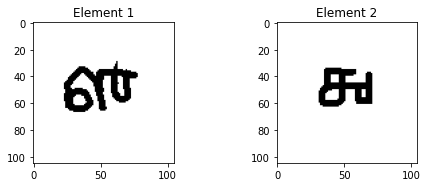

In [ ]:
# creating the training and validation generators 
cl_train_gen = PairDataGenerator(X_train, Y_train[:, 0], batch_size, steps_per_epoch) 
cl_dev_gen = PairDataGenerator(X_val, Y_val[:, 0], valid_batch_size, valid_batch_size) 
cl_test_gen = PairDataGenerator(X_test, Y_test[:, 0], valid_batch_size, steps_per_epoch)
cl_combined_gen = PairDataGenerator(X_combined, Y_combined[:, 0], valid_batch_size, steps_per_epoch)
[x1, x2], y = cl_train_gen.__getitem__(0)
# visualizing some examples
print_cl_batch(*cl_train_gen.__getitem__(0))

In [ ]:
# building the siamese network
x_in_1 = tf.keras.Input((105, 105, 3))
x_in_2 = tf.keras.Input((105, 105, 3))

branch = build_network()
branch_1 = branch(x_in_1)
branch_2 = branch(x_in_2)
x_out = tf.keras.layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([branch_1, branch_2])

siamese_model_1 = tf.keras.Model([x_in_1, x_in_2], x_out)

# defing the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=Adam_lr)

# compiling the network with loss and optimizers
siamese_model_1.compile(optimizer=optimizer, loss=contrastive_loss(margin))

In [ ]:
def scheduler(epoch, lr):
    """the learning rate schedule on how to decay during training.

    Args:
        epoch (int): number of training iterations
        lr (float): the initial learning

    Returns:
        (float): the decayed learning rate
    """
    return lr * 0.8 if epoch % 2 == 0 else lr

# training starts
siamese_history_1 = siamese_model_1.fit_generator(
                    generator=cl_train_gen,
                    validation_data=cl_dev_gen,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)]
                )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
256/256 [==============================] - 35s 123ms/step - loss: 11.6226 - val_loss: 1.2412
Epoch 2/10
256/256 [==============================] - 31s 121ms/step - loss: 0.9235 - val_loss: 1.0624
Epoch 3/10
256/256 [==============================] - 31s 121ms/step - loss: 0.9300 - val_loss: 1.1339
Epoch 4/10
256/256 [==============================] - 31s 120ms/step - loss: 0.9116 - val_loss: 1.3391
Epoch 5/10
256/256 [==============================] - 31s 120ms/step - loss: 0.8712 - val_loss: 1.1936
Epoch 6/10
256/256 [==============================] - 31s 120ms/step - loss: 0.8918 - val_loss: 1.1437
Epoch 7/10
256/256 [==============================] - 31s 120ms/step - loss: 0.7711 - val_loss: 1.0137
Epoch 8/10
256/256 [==============================] - 31s 120ms/step - loss: 0.7896 - val_loss: 1.1442
Epoch 9/10
256/256 [==============================] - 31s 120ms/step - loss: 0.6645 - val_loss: 0.8008
Epoch 10/10
256/256 [==============================] - 31s 120ms/step - 

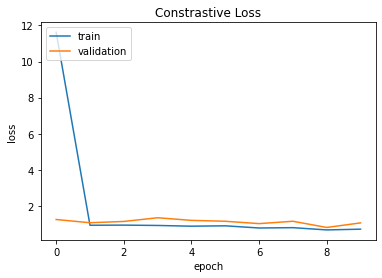

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the training loss
plt_metric(history=siamese_history_1.history, metric="loss", title="Constrastive Loss")

In [ ]:
# compute performance on training dataset
loss = 0
loss_fn = contrastive_loss(margin)
for i, batch in enumerate(cl_train_gen):
  predictions = siamese_model_1.predict(batch[0], verbose=0)
  predictions = tf.convert_to_tensor(predictions)
  loss += loss_fn(batch[1], predictions)

print(f'Train loss: {loss/(i+1)}')

Train loss: 0.4506465792655945


In [ ]:
# compute performance on test dataset
loss = 0
for i, batch in enumerate(cl_combined_gen):
  predictions = siamese_model_1.predict(batch[0], verbose=0)
  predictions = tf.convert_to_tensor(predictions)
  loss += loss_fn(batch[1], predictions)

print(f'All dataset loss: {loss/(i+1)}')

All dataset loss: 0.4570419490337372


In [ ]:
# compute performance on test dataset
loss = 0
for i, batch in enumerate(cl_test_gen):
  predictions = siamese_model_1.predict(batch[0], verbose=0)
  predictions = tf.convert_to_tensor(predictions)
  loss += loss_fn(batch[1], predictions)

print(f'Test loss: {loss/(i+1)}')

Test loss: 0.45406627655029297


Contrastive loss:  0.91474867
Label is:  [False]


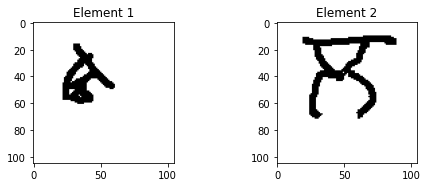

In [ ]:
cl_vis_gen = PairDataGenerator(X_test, Y_test[:, 0], 1, steps_per_epoch)
loss_fn = contrastive_loss(margin)
for batch in cl_vis_gen:
  predictions = siamese_model_1.predict(batch[0], verbose=0)
  predictions = tf.convert_to_tensor(predictions)
  loss = loss_fn(batch[1], predictions)
  print('Contrastive loss: ', loss.numpy())
  print('Label is: ', batch[1])
  print_cl_batch(*batch)
  break


## Triplet loss data generator

In [ ]:
class TripletDataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, data, labels, batch_size, steps_per_epoch):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        
    def __len__(self):
        return self.steps_per_epoch
    
    def __gettriplet__(self, char_id):
        mask = self.labels[:, 0] == char_id
        ap = shuffle(self.data[mask])[:2]
        n = shuffle(self.data[~mask])[0]
        return load_image(ap[0]), load_image(ap[1]), load_image(n)
    
    def __getitem__(self, index):
        """get one triplet images and label.

        Args:
            index (int): index of the triplet in the dataset

        Returns:
            (list): triplet of the images
            (np.array): anchor IDs
        """
        char_ids = np.unique(self.labels[:, 0])
        anchor_ids = shuffle(char_ids)[:self.batch_size]
        x_a = []
        x_p = []
        x_n = []
        for char_id in anchor_ids:
            a, p, n = self.__gettriplet__(char_id)
            x_a.append(a)
            x_p.append(p)
            x_n.append(n)
        x_a = np.array(x_a)
        x_p = np.array(x_p)
        x_n = np.array(x_n)
        return [x_a, x_p, x_n], anchor_ids

def euclidian_distance(v1, v2):
    return tf.sqrt(tf.reduce_sum(tf.square(v1 - v2), axis=-1) + 1e-16)

def triplet_loss(margin):
    """The triplet loss implementation.

    Args:
        margin (float): allowed distance between the positive and negatives

    Returns:
        (tf.float): triplet loss of the batch
    """
    def loss(y_true, y_pred):
        total_lenght = y_pred.shape.as_list()[-1]
        anchors = y_pred[:,0:int(total_lenght*1/3)]
        positives = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
        negatives = y_pred[:,int(total_lenght*2/3):]
        pos_dist = euclidian_distance(anchors, positives)
        neg_dist = euclidian_distance(anchors, negatives)
        return tf.reduce_mean(tf.maximum((pos_dist - neg_dist) + margin, 0.0))
    return loss

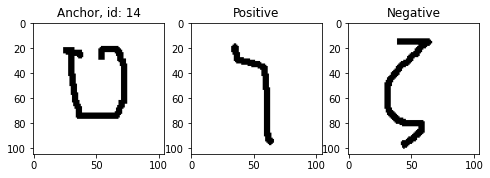

In [ ]:
# training and validation data generators
tl_train_gen = TripletDataGenerator(X_train, Y_train, batch_size, steps_per_epoch)
tl_valid_gen = TripletDataGenerator(X_val, Y_val, valid_batch_size, steps_per_epoch)
tl_test_gen = TripletDataGenerator(X_test, Y_test, valid_batch_size, steps_per_epoch)
tl_combined_gen = TripletDataGenerator(X_combined, Y_combined, valid_batch_size, steps_per_epoch)
print_tl_batch(*tl_train_gen.__getitem__(0))

In [ ]:
# building the siames network with three branches
x_in_a = tf.keras.Input((105, 105, 3))
x_in_p = tf.keras.Input((105, 105, 3))
x_in_n = tf.keras.Input((105, 105, 3))

branch2 = build_network()
branch_a = branch2(x_in_a)
branch_p = branch2(x_in_p)
branch_n = branch2(x_in_n)
x_out = tf.keras.layers.Concatenate()([branch_a, branch_p, branch_n])
siamese_model_2 = tf.keras.Model([x_in_a, x_in_p, x_in_n], x_out)

# forming the optimizer and compiling with the model
optimizer = tf.keras.optimizers.Adam(learning_rate=Adam_lr)
siamese_model_2.compile(optimizer=optimizer, loss=triplet_loss(margin))

In [ ]:
# training starts
siamese_history_2 = siamese_model_2.fit_generator(
                    generator=tl_train_gen,
                    validation_data=tl_valid_gen,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)]
                )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
256/256 [==============================] - 32s 113ms/step - loss: 13.0143 - val_loss: 4.2940
Epoch 2/10
256/256 [==============================] - 28s 111ms/step - loss: 3.5415 - val_loss: 3.1547
Epoch 3/10
256/256 [==============================] - 28s 111ms/step - loss: 2.8696 - val_loss: 2.6379
Epoch 4/10
256/256 [==============================] - 29s 111ms/step - loss: 3.0889 - val_loss: 3.0594
Epoch 5/10
256/256 [==============================] - 28s 111ms/step - loss: 2.6882 - val_loss: 2.4182
Epoch 6/10
256/256 [==============================] - 29s 111ms/step - loss: 2.4892 - val_loss: 2.5019
Epoch 7/10
256/256 [==============================] - 28s 110ms/step - loss: 2.1738 - val_loss: 2.6524
Epoch 8/10
256/256 [==============================] - 28s 111ms/step - loss: 2.0826 - val_loss: 2.2638
Epoch 9/10
256/256 [==============================] - 28s 111ms/step - loss: 2.0657 - val_loss: 2.4599
Epoch 10/10
256/256 [==============================] - 29s 114ms/step - 

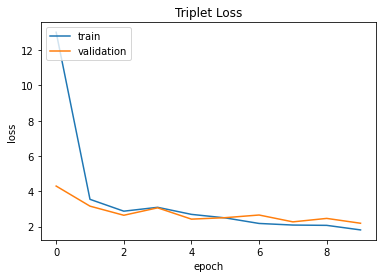

In [ ]:
# Plot the training loss
plt_metric(history=siamese_history_2.history, metric="loss", title="Triplet Loss")

In [ ]:
# compute performance on training dataset
loss_fn = triplet_loss(margin)
for i, batch in enumerate(tl_train_gen):
  predictions = siamese_model_2.predict(batch[0], verbose=0)
  predictions = tf.convert_to_tensor(predictions)
  loss += loss_fn(batch[1], predictions)

print(f'Train loss: {loss/(i+1)}')

Train loss: 1.0026479959487915


In [ ]:
# compute performance on all dataset
for i, batch in enumerate(tl_combined_gen):
  predictions = siamese_model_2.predict(batch[0], verbose=0)
  predictions = tf.convert_to_tensor(predictions)
  loss += loss_fn(batch[1], predictions)

print(f'All dataset loss: {loss/(i+1)}')

All dataset loss: 2.00185227394104


In [ ]:
# compute performance on test dataset
for i, batch in enumerate(tl_test_gen):
  predictions = siamese_model_2.predict(batch[0], verbose=0)
  predictions = tf.convert_to_tensor(predictions)
  loss += loss_fn(batch[1], predictions)

print(f'Test loss: {loss/(i+1)}')

Test loss: 3.0007786750793457


Triplet loss of the example:  1.0017498


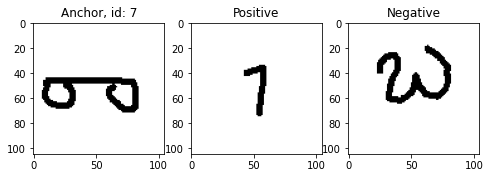

In [ ]:
tl_vis_gen = TripletDataGenerator(X_test, Y_test, 1, steps_per_epoch)
for batch in tl_vis_gen:
  # print(batch)
  predictions = siamese_model_2.predict(batch[0], verbose=0)
  predictions = tf.convert_to_tensor(predictions)
  loss = loss_fn(batch[1], predictions)
  print('Triplet loss of the example: ', loss.numpy())
  print_tl_batch(*batch)
  break
